Carregamento do dataset MNIST:
fetch_openml('mnist_784', version=1): Carrega o dataset MNIST da biblioteca fetch_openml, especificando a versão 1 do dataset.
X = mnist.data: Armazena os dados de pixels das imagens no DataFrame X.
y = mnist.target.astype(np.int8): Armazena as labels (classes) das imagens no vetor y, convertendo-as para inteiros de 8 bits para otimizar o armazenamento.
Filtrando as classes:
mask = (y == 2) | (y == 4) | (y == 7): Cria uma máscara booleana que seleciona apenas as imagens das classes 2, 4 e 7.
X = X[mask]: Filtra o DataFrame X usando a máscara, mantendo apenas as imagens das classes 2, 4 e 7.
y = y[mask]: Filtra o vetor de labels y usando a máscara, mantendo apenas as labels correspondentes às imagens em X após o filtro.
Seleção de pixels:
k_features = 50: Define o número de pixels (recursos) a serem selecionados para o modelo.
selector = SelectKBest(mutual_info_classif, k=k_features): Cria um objeto SelectKBest para selecionar os pixels mais informativos, utilizando a métrica mutual_info_classif para medir a informação mútua entre os pixels e a classe.
X_selected = selector.fit_transform(X, y): Seleciona os k_features pixels mais informativos e armazena os dados selecionados em X_selected.
feature_names = [f'pixel_{i}' for i in range(X_selected.shape[1])]: Cria uma lista com os nomes dos pixels selecionados, usando o formato "pixel_i".
Normalização dos dados:
scaler = StandardScaler(): Cria um objeto StandardScaler para normalizar os dados, que é uma técnica comum para melhorar o desempenho de modelos de machine learning.
X_selected = scaler.fit_transform(X_selected): Normaliza os dados selecionados em X_selected para que tenham média zero e desvio padrão 1.
Treinando o modelo de regressão logística:
model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=200): Cria um modelo de regressão logística usando o método "one-vs-rest" (multi_class='ovr') e o otimizador "lbfgs" (solver='lbfgs'). Define o número máximo de iterações (max_iter) para 200.
model.fit(X_selected, y): Treina o modelo de regressão logística usando os dados selecionados e normalizados (X_selected) e as labels (y).
Verificando as classes treinadas:
print("Classes treinadas pelo modelo:", model.classes_): Imprime as classes que o modelo foi treinado para prever.
Verificando as dimensões dos coeficientes e interceptos:
print("Dimensões dos coeficientes (pesos) do modelo:", model.coef_.shape): Imprime as dimensões da matriz de coeficientes do modelo.
print("Dimensões dos interceptos (viés) do modelo:", model.intercept_.shape): Imprime as dimensões do vetor de interceptos do modelo.
Função minimal_explanation:
Essa função utiliza o Z3 Solver para encontrar uma explicação minimal para a previsão do modelo, mostrando quais pixels (recursos) são mais importantes para a previsão.
Z3 Solver: O Z3 Solver é uma ferramenta de resolução de restrições (SAT) que pode ser utilizada para encontrar soluções para problemas lógicos.
Restrições: A função define restrições para garantir que a função de decisão da classe alvo seja maior que a função de decisão de outras classes, com uma margem de epsilon.
Minimização: A função de otimização do Z3 Solver é configurada para minimizar o número de recursos selecionados.
Explicação minimal: Se o solver encontrar uma solução, ele retorna o resultado, a lista de índices dos recursos selecionados e os nomes dos recursos selecionados.
Exemplo de uso:
Selecionando uma instância: Um índice de instância é selecionado e a imagem correspondente é extraída do DataFrame X, convertendo-a para um array NumPy.
Previsão: A classe prevista pelo modelo para a instância é obtida.
Explicação minimal: A função minimal_explanation é chamada para calcular a explicação minimal usando os dados normalizados e a classe prevista.
Visualização: Se uma explicação for encontrada, a imagem é plotada, destacando os pixels irrelevantes em vermelho.
Em resumo, este código demonstra como usar um modelo de regressão logística para classificar imagens do dataset MNIST, com a técnica de seleção de recursos SelectKBest e uma explicação minimal usando o Z3 Solver.

Classes treinadas pelo modelo: [2 4 7]
Dimensões dos coeficientes (pesos) do modelo: (classes, pixels) (3, 50)
Dimensões dos interceptos (viés) do modelo: (3,)
Tamanho de X: 21107 quantidade de imagens das classes selecionadas
Colunas de X: Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)
Classe prevista pelo modelo para a instância: 4
Objective: Minimize selected features
Solver result: sat
Model found. Explanation (indices): [0, 25]
Explicação minimal (nomes das características): ['pixel_0', 'pixel_25']


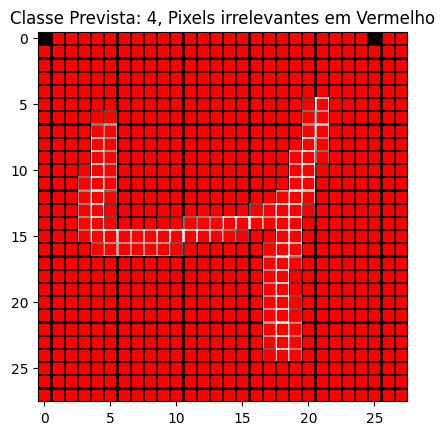

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from z3 import *
import matplotlib.pyplot as plt

# 1. Carregando o dataset MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data  # Matriz com os dados de pixels das imagens 
y = mnist.target.astype(np.int8)  # Vetor com as labels (classes) das imagens, convertendo-as para inteiros de 8 bits


# 2. Selecionando apenas as classes 2, 4 e 7
mask = (y == 2) | (y == 4) | (y == 7)  # Criando uma máscara booleana para selecionar as classes desejadas
X = X[mask]  # Filtrando os dados para manter apenas as imagens das classes 2, 4 e 7
y = y[mask]  # Filtrando as labels para manter apenas as labels das classes 2, 4 e 7

# 3. Seleção de Pixels
k_features = 50  # Número de recursos (pixels) a serem selecionados
selector = SelectKBest(mutual_info_classif, k=k_features)  # Criando um objeto SelectKBest para selecionar os pixels mais informativos de k_features
X_selected = selector.fit_transform(X, y)  # Aplicando a seleção de recursos para selecionar os melhores k_features pixels
feature_names = [f'pixel_{i}' for i in range(X_selected.shape[1])]  # Criando nomes para os pixels selecionados

# 4. Normalizando os dados
scaler = StandardScaler()  # Criando um objeto StandardScaler para normalizar os dados
X_selected = scaler.fit_transform(X_selected)  # Normalizando os dados selecionados

# 5. Treinando o modelo de regressão logística
model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=200)  # Criando um modelo de regressão logística
model.fit(X_selected, y)  # Treinando o modelo com os dados selecionados e normalizados

# 6. Verificando as classes treinadas imprimindo na tela as classes treinadas pelo modelo
print("Classes treinadas pelo modelo:", model.classes_)

# 7. Verificando as dimensões dos coeficientes e interceptos
print("Dimensões dos coeficientes (pesos) do modelo: (classes, pixels)", model.coef_.shape)

''' pesos o resultado seria uma tupla com 2 numeros o primeiro é a quantidade de classes
    o segundo a quantidade de pixels depois de ter sido selecionados com o SelectKBest
    para selecionar os 50 pixels mais informativos para a classificação.'''

print("Dimensões dos interceptos (viés) do modelo:", model.intercept_.shape)

# 8. Função para criar uma explicação minimal usando Z3 Solver
def minimal_explanation(model, instance, target_class, epsilon=0.2, timeout=60000):
    num_features = instance.shape[0]  # Número de recursos na instância (pixels selecionados)
    weights = model.coef_  # Obtendo a matriz - Pesos do modelo (coeficientes)
    intercepts = model.intercept_  # Interceptos do modelo (viés)
    
    # Z3 Optimize
    opt = Optimize()  # Criando um objeto Optimize para o Z3 Solver
    opt.set("timeout", timeout)  # Definindo um limite de tempo para o solver (60000 milissegundos = 1 minuto) para não demorar muito
    
    # Variáveis Z3 (representando a seleção de recursos)
    feature_selection = [Bool(f'f{i}') for i in range(num_features)]  # Criando variáveis booleanas para cada recurso (pixel)

    # Função de decisão do modelo (usada para definir as restrições do Z3)
    def decision_function(weights, intercept, instance, selected_features):
        return Sum([If(selected_features[i], instance[i] * weights[i], 0) for i in range(num_features)]) + intercept
    ''' observar o ( 0 ) depois do peso  pode estar errado'''
    # Obter o índice da classe alvo
    target_index = np.where(model.classes_ == target_class)[0][0]  # Encontrando o índice da classe alvo

    # Adicionar restrições ao solver
    for i in range(len(model.classes_)):
        if i != target_index:  # Para cada classe diferente da classe alvo
            decision_target = decision_function(weights[target_index], intercepts[target_index], instance, feature_selection)  # Calculando a função de decisão para a classe alvo
            decision_other = decision_function(weights[i], intercepts[i], instance, feature_selection)  # Calculando a função de decisão para outra classe
            
            # Relaxamento das Restrições: Ajuste da folga (epsilon)
            constraint = decision_target > decision_other + epsilon  # Definindo a restrição para a função de decisão da classe alvo ser maior que a função de decisão das outras classes com uma margem (epsilon)
            opt.add(constraint)  # Adicionando a restrição ao solver

    # Minimizar o número de características selecionadas
    opt.minimize(Sum([If(f, 1, 0) for f in feature_selection]))  # Definindo a função de otimização para minimizar o número de recursos selecionados

    # Check satisfiability and get the model if possible
    result = opt.check()  # Verificando se o Z3 Solver encontrou uma solução satisfazendo as restrições

    if result == sat:  # Se o solver encontrou uma solução
        m = opt.model()  # Obtendo o modelo (interpretação) do solver
        explanation = [i for i in range(num_features) if m.evaluate(feature_selection[i])]  # Identificando os recursos (pixels) selecionados na explicação minimal
        explanation_features = [feature_names[i] for i in explanation]  # Obtendo os nomes dos recursos (pixels) selecionados
        return result, explanation, explanation_features  # Retornando o resultado do solver, a lista de índices dos recursos selecionados e os nomes dos recursos selecionados
    else:  # Se o solver não encontrou uma solução
        return result, None, None  # Retornando None para a explicação

# 9. Verificação do dataset e explicação com os dados normalizados
print(f"Tamanho de X: {len(X)} quantidade de imagens das classes selecionadas") # Verifica o tamanho de X (imagens)
print(f"Colunas de X: {X.columns}") # Imprime as colunas de X
instance_index = 0 # Escolha um índice de instância válido (menor que o tamanho de X)
instance = X.iloc[instance_index].to_numpy()  # Selecionando a instância (imagem) do conjunto de dados e convertendo para array numpy
target_class = model.predict([X_selected[instance_index]])[0]  # Obtendo a classe prevista pelo modelo para a instância

print("Classe prevista pelo modelo para a instância:", target_class)

# Calcula a explicação minimal usando os dados normalizados
result, explanation, explanation_features = minimal_explanation(model, X_selected[instance_index], target_class)

if explanation:
    print("Objective: Minimize selected features")
    print("Solver result:", result)
    print("Model found. Explanation (indices):", explanation)
    print("Explicação minimal (nomes das características):", explanation_features)

    # Plota a imagem com os pixels irrelevantes em vermelho
    plt.imshow(instance.reshape(28, 28), cmap='gray')
    
    # Pinta de vermelho os pixels irrelevantes (não presentes na explicação minimal)
    for i in range(len(instance)):
        if i not in explanation:
            row = i // 28  # Calcula a linha do pixel
            col = i % 28  # Calcula a coluna do pixel
            plt.scatter(col, row, color='red', marker='s', s=50)

    plt.title(f"Classe Prevista: {target_class}, Pixels irrelevantes em Vermelho")
    plt.show()
else:
    print("No solution found")